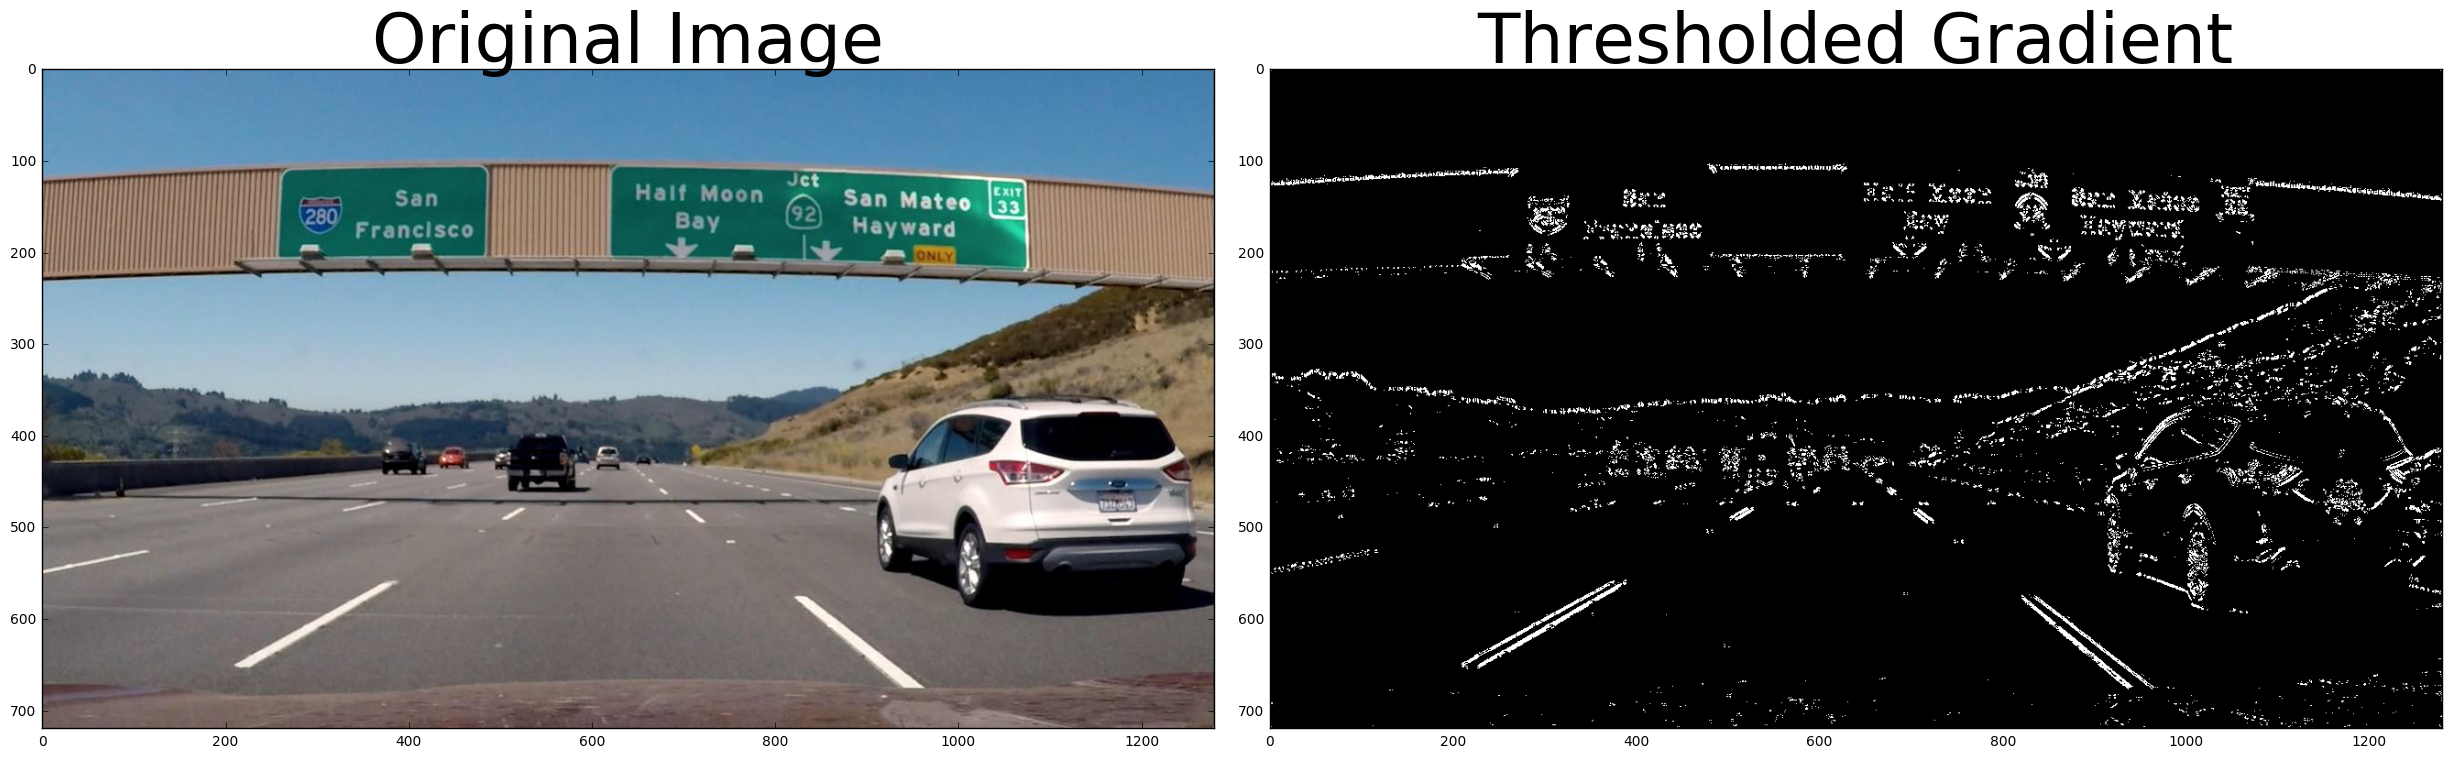

In [42]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise Error("Unsupported direction for gradient")
    # Apply threshold
    abs_sobel = np.absolute(sobel)
    abs_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(abs_sobel)
    grad_binary[(abs_sobel >= thresh[0]) & (abs_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate directional gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate directional gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(sobel_dir)
    dir_binary[(sobel_dir >= thresh[0]) & (sobel_dir <= thresh[1])] = 1
    return dir_binary


def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0]) & (s<=thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary


image = mpimg.imread("signs_vehicles_xygrad.jpg")

pipeline_binary = pipeline(image)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

hls_binary = hls_select(image, thresh=(90, 255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ax1.imshow(gray, cmap='gray')
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()